In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

from Blocks import Transformer, Data, MeanNormalization, get_size

In [13]:
data = torch.load("Data.pt")

temp = list(data.columns)
cols = temp[1:]
cols.append("Label")
data = data[cols].drop(columns = ["Close", "Adj Close"])
data = data.astype(float)
data.head(2)

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,...,Neu21,Neu22,Neu23,Neu24,Neu25,Open,High,Low,Volume,Label
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0.066467,0.020223,0.043872,0.021866,0.01509,0.023724,0.051096,0.026434,0.012361,0.040297,...,0.873544,0.204416,0.538325,0.487061,0.411749,11432.089844,11759.959961,11388.040039,212830000.0,0.0
2008-08-11,0.071691,0.049347,0.932647,0.034207,0.02592,0.025570,0.018784,0.017460,0.055654,0.025160,...,0.534569,0.183160,0.895037,0.493829,0.930178,11729.669922,11867.110352,11675.530273,183190000.0,1.0


In [14]:
data = torch.FloatTensor(data.values)
data.shape

torch.Size([1989, 80])

In [15]:
n = 0.85    #Train data precentage
rows = data.shape[0]

train_data = data[:int(rows*n),:]
test_data = data[int(rows*n):,:]
train_data.shape, test_data.shape

(torch.Size([1690, 80]), torch.Size([299, 80]))

In [16]:
d_set_train = Data(train_data, win_len=30, stride=1, transform = MeanNormalization())
d_set_test = Data(test_data, win_len=30, stride=1, transform = MeanNormalization())

torch.Size([1690, 80])
torch.Size([299, 80])


In [17]:
trainloader = DataLoader(dataset=d_set_train, batch_size = 16)
testloader = DataLoader(dataset=d_set_test, batch_size = 16)

In [18]:
device = torch.device('cuda:0')
model = Transformer(embed_dim=79, enc_expansion=4, dec_expansion=4, enc_heads=8, dec_heads=8,
                    num_enc=6, num_dec=6, pos_enc=True, device=device)

In [19]:
get_size(model)

'model size: 38652544 / bit | 4.83 / MB'

<center><h1>Training

In [20]:
from torch import optim

In [21]:
model.to(device)
criterion = nn.BCELoss()

optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
epochs = 100

Epoch : 0, Batch : 100, Train Loss : 0.6953780651092529, Validation Loss : 0.6981419920921326, Validation Accuracy : 0.5054320693016052


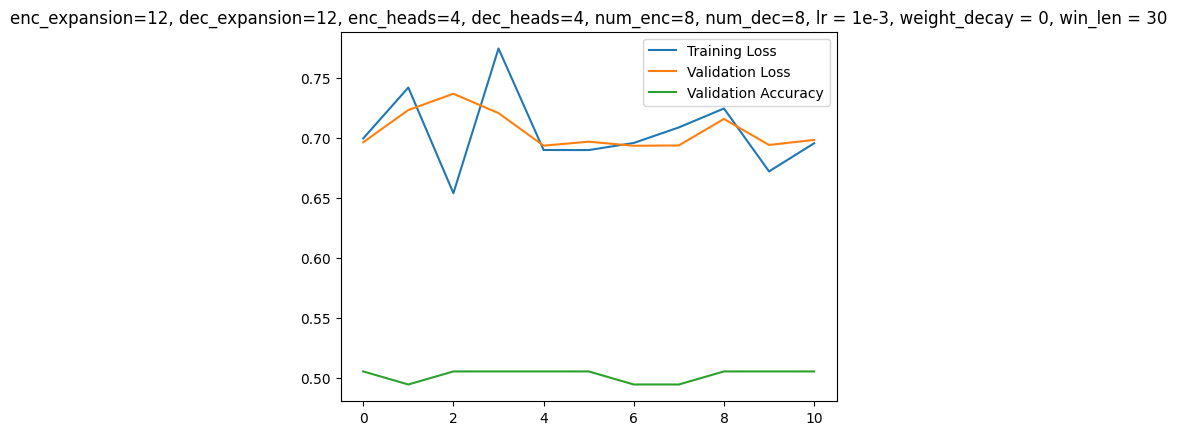

CPU times: total: 2min 4s
Wall time: 39.1 s


In [23]:
%%time
train_loss = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    for i,(x,y) in enumerate(trainloader):
        model.train()
        x = x.to(device)
        y = y.to(device)

        yhat = model(x, y)
        loss = criterion(yhat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%50 == 0:
            v_loss, v_acc, total_correct, total_samples = 0, 0, 0, 0
            for xv, yv in testloader:
                xv = xv.to(device)
                yv = yv.to(device)
                model.eval()
                y_vhat = model(xv, yv)

                v_loss += criterion(y_vhat,yv)
                y_vhat = torch.round(y_vhat)
                total_correct += (y_vhat == yv).sum()
                total_samples += yv.numel()

            v_acc = total_correct / total_samples
            val_acc.append(v_acc.data.cpu().numpy())
            v_loss = v_loss/len(testloader)
            val_loss.append(v_loss.data.cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            clear_output(wait = True)
            print(f"Epoch : {epoch}, Batch : {i}, Train Loss : {loss.data}, Validation Loss : {v_loss.data}, Validation Accuracy : {v_acc}")
            
            plt.plot(train_loss, label = "Training Loss")
            plt.plot(val_loss, label = "Validation Loss")
            plt.plot(val_acc, label = "Validation Accuracy")
            plt.title("enc_expansion=12, dec_expansion=12, enc_heads=4, dec_heads=4, num_enc=8, num_dec=8, lr = 1e-3, weight_decay = 0, win_len = 30")
            plt.legend()
            plt.show()